In [18]:
from pyspark import SparkContext
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.types import *
import pandas as pd
import numpy as np
from pyspark.sql.functions import *
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import operator
#from pyspark.sql.functions import regexp_replace
#from pyspark.sql.functions import udf  # user defined function
#from pyspark.sql.functions import to_date
#from pyspark.sql.functions import datediff
from wordcloud import WordCloud, STOPWORDS
from subprocess import check_output
from pyspark.ml.linalg import Vectors  
from pyspark.ml.feature import VectorAssembler ,HashingTF, Tokenizer
from pyspark.ml.feature import StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator


sc=SparkContext.getOrCreate()
sqlContext = SQLContext(sc)
spark = SparkSession.builder.appName('pandasToSparkDF').getOrCreate()

In [19]:
mySchema = StructType([ StructField("Video_Id", StringType(), True)\
                       ,StructField("Trending_Date", StringType(), True)\
                       ,StructField("Title", StringType(), True)\
                       ,StructField("Channel_Title", StringType(), True)\
                       ,StructField("Category_Id", IntegerType(), True)\
                       ,StructField("Publish_Time", StringType(), True)\
                       ,StructField("Tags", StringType(), True)\
                       ,StructField("Views", IntegerType(), True)\
                       ,StructField("Likes", IntegerType(), True)\
                       ,StructField("Dislikes", IntegerType(), True)\
                       ,StructField("Comments", IntegerType(), True)])

<h1>Opening and Cleaning<h1>

In [20]:
ca_pdDF = pd.read_csv("CAvideos.csv")
ca_pdDF.drop(ca_pdDF.columns[[11,12,13,14,15]], axis=1, inplace=True)
ca_df = spark.createDataFrame(ca_pdDF,schema=mySchema)

In [21]:
de_pdDF = pd.read_csv("DEvideos.csv")
de_pdDF.drop(de_pdDF.columns[[11,12,13,14,15]], axis=1, inplace=True)
de_df = spark.createDataFrame(de_pdDF,schema=mySchema)

In [22]:
fr_pdDF = pd.read_csv("FRvideos.csv")
fr_pdDF.drop(fr_pdDF.columns[[11,12,13,14,15]], axis=1, inplace=True)
fr_df = spark.createDataFrame(fr_pdDF,schema=mySchema)

In [23]:
gb_pdDF = pd.read_csv("GBvideos.csv")
gb_pdDF.drop(gb_pdDF.columns[[11,12,13,14,15]], axis=1, inplace=True)
gb_df = spark.createDataFrame(gb_pdDF,schema=mySchema)

In [24]:
us_pdDF = pd.read_csv("USvideos.csv")
us_pdDF.drop(us_pdDF.columns[[11,12,13,14,15]], axis=1, inplace=True)
us_df = spark.createDataFrame(us_pdDF,schema=mySchema)
us_df.show()

+-----------+-------------+--------------------+--------------------+-----------+--------------------+--------------------+-------+------+--------+--------+
|   Video_Id|Trending_Date|               Title|       Channel_Title|Category_Id|        Publish_Time|                Tags|  Views| Likes|Dislikes|Comments|
+-----------+-------------+--------------------+--------------------+-----------+--------------------+--------------------+-------+------+--------+--------+
|2kyS6SvSYSE|     17.14.11|WE WANT TO TALK A...|        CaseyNeistat|         22|2017-11-13T17:13:...|     SHANtell martin| 748374| 57527|    2966|   15954|
|1ZAPwfrtAFY|     17.14.11|The Trump Preside...|     LastWeekTonight|         24|2017-11-13T07:30:...|last week tonight...|2418783| 97185|    6146|   12703|
|5qpjK5DgCt4|     17.14.11|Racist Superman |...|        Rudy Mancuso|         23|2017-11-12T19:05:...|racist superman|"...|3191434|146033|    5339|    8181|
|puqaWrEC7tY|     17.14.11|Nickelback Lyrics...|Good Mythi

In [25]:
parse_date = udf(lambda date: date.split("T")[0])
ca_df = ca_df.withColumn("Publish_Time", parse_date(ca_df.Publish_Time))
ca_df=ca_df.withColumn("Trending_Date",regexp_replace("Trending_Date","\\.","-"))
ca_df= ca_df.withColumn("Trending_Date", to_date("Trending_Date", "yy-dd-MM"))



de_df = de_df.withColumn("Publish_Time", parse_date(de_df.Publish_Time))
de_df=de_df.withColumn("Trending_Date",regexp_replace("Trending_Date","\\.","-"))
de_df= de_df.withColumn("Trending_Date", to_date("Trending_Date", "yy-dd-MM"))


fr_df= fr_df.withColumn("Publish_Time", parse_date(fr_df.Publish_Time))
fr_df=fr_df.withColumn("Trending_Date",regexp_replace("Trending_Date","\\.","-"))
fr_df= fr_df.withColumn("Trending_Date", to_date("Trending_Date", "yy-dd-MM"))


gb_df = gb_df.withColumn("Publish_Time", parse_date(gb_df.Publish_Time))
gb_df=gb_df.withColumn("Trending_Date",regexp_replace("Trending_Date","\\.","-"))
gb_df= gb_df.withColumn("Trending_Date", to_date("Trending_Date", "yy-dd-MM"))



us_df = us_df.withColumn("Publish_Time", parse_date(us_df.Publish_Time))
us_df=us_df.withColumn("Trending_Date",regexp_replace("Trending_Date","\\.","-"))
us_df= us_df.withColumn("Trending_Date", to_date("Trending_Date", "yy-dd-MM"))

In [26]:
ca_df=ca_df.withColumn("Time_Passed", datediff("Trending_Date","Publish_Time"))

de_df=de_df.withColumn("Time_Passed", datediff("Trending_Date","Publish_Time"))

fr_df=fr_df.withColumn("Time_Passed", datediff("Trending_Date","Publish_Time"))

gb_df=gb_df.withColumn("Time_Passed", datediff("Trending_Date","Publish_Time"))

us_df=us_df.withColumn("Time_Passed", datediff("Trending_Date","Publish_Time"))

In [27]:
us_df.show()

+-----------+-------------+--------------------+--------------------+-----------+------------+--------------------+-------+------+--------+--------+-----------+
|   Video_Id|Trending_Date|               Title|       Channel_Title|Category_Id|Publish_Time|                Tags|  Views| Likes|Dislikes|Comments|Time_Passed|
+-----------+-------------+--------------------+--------------------+-----------+------------+--------------------+-------+------+--------+--------+-----------+
|2kyS6SvSYSE|   2017-11-14|WE WANT TO TALK A...|        CaseyNeistat|         22|  2017-11-13|     SHANtell martin| 748374| 57527|    2966|   15954|          1|
|1ZAPwfrtAFY|   2017-11-14|The Trump Preside...|     LastWeekTonight|         24|  2017-11-13|last week tonight...|2418783| 97185|    6146|   12703|          1|
|5qpjK5DgCt4|   2017-11-14|Racist Superman |...|        Rudy Mancuso|         23|  2017-11-12|racist superman|"...|3191434|146033|    5339|    8181|          2|
|puqaWrEC7tY|   2017-11-14|Nickelb

<h1>What are top 10 channels in top countries?	<h1>
Ratio= Likes / Dislikes

Score= Views * Ratio

In [57]:
ca_ratio=ca_df.groupBy("Channel_Title").agg(sum("views").alias("Views"), (sum("likes")/sum("dislikes")).alias("Ratio"))
ca_ratio=ca_ratio.filter(~col("Ratio").isin(["null"]))
de_ratio=de_df.groupBy("Channel_Title").agg(sum("views").alias("Views"), (sum("likes")/sum("dislikes")).alias("Ratio"))
de_ratio=de_ratio.filter(~col("Ratio").isin(["null"]))
fr_ratio=fr_df.groupBy("Channel_Title").agg(sum("views").alias("Views"), (sum("likes")/sum("dislikes")).alias("Ratio"))
fr_ratio=fr_ratio.filter(~col("Ratio").isin(["null"]))
gb_ratio=gb_df.groupBy("Channel_Title").agg(sum("views").alias("Views"), (sum("likes")/sum("dislikes")).alias("Ratio"))
gb_ratio=gb_ratio.filter(~col("Ratio").isin(["null"]))
us_ratio=us_df.groupBy("Channel_Title").agg(sum("views").alias("Views"), (sum("likes")/sum("dislikes")).alias("Ratio"))
us_ratio=us_ratio.filter(~col("Ratio").isin(["null"]))

In [58]:
top_dict={}
for row in ca_ratio.collect():
    top_dict.setdefault(row.Channel_Title, 0)
    top_dict[row.Channel_Title] += (row.Views*row.Ratio)
for row in de_ratio.collect():
    top_dict.setdefault(row.Channel_Title, 0)
    top_dict[row.Channel_Title] += (row.Views*row.Ratio)
for row in fr_ratio.collect():
    top_dict.setdefault(row.Channel_Title, 0)
    top_dict[row.Channel_Title] += (row.Views*row.Ratio)
for row in gb_ratio.collect():
    top_dict.setdefault(row.Channel_Title, 0)
    top_dict[row.Channel_Title] += (row.Views*row.Ratio)
for row in us_ratio.collect():
    top_dict.setdefault(row.Channel_Title, 0)
    top_dict[row.Channel_Title] += (row.Views*row.Ratio)
my_dict_end = sorted(top_dict.items(), key=operator.itemgetter(1), reverse = True)[0:10]
my_dict_end

[(u'Marvel Entertainment', 351613211283.4072),
 (u'DrakeVEVO', 340049538261.99005),
 (u'ibighit', 305524187085.5034),
 (u'Ed Sheeran', 217544253588.25345),
 (u'NickyJamTV', 182224180744.36942),
 (u'Bad Bunny', 142633326336.1615),
 (u'20th Century Fox', 132429527883.75476),
 (u'TheWeekndVEVO', 127023678899.5016),
 (u'Dude Perfect', 124279139749.37363),
 (u'SMTOWN', 120270999101.58934)]

In [59]:
topSchema = StructType([ StructField("Channel_Name", StringType(), True)\
                       ,StructField("Score", FloatType(), True)])
top_ten = spark.createDataFrame(my_dict_end, schema=topSchema).sort(desc("Score"))
top_ten.show()

+--------------------+-------------+
|        Channel_Name|        Score|
+--------------------+-------------+
|Marvel Entertainment|3.51613223E11|
|           DrakeVEVO|3.40049527E11|
|             ibighit|3.05524179E11|
|          Ed Sheeran|2.17544262E11|
|          NickyJamTV|1.82224175E11|
|           Bad Bunny| 1.4263332E11|
|    20th Century Fox|1.32429529E11|
|       TheWeekndVEVO|1.27023677E11|
|        Dude Perfect|1.24279136E11|
|              SMTOWN|1.20270995E11|
+--------------------+-------------+



Text(0.5,0,u'Name of Channels')

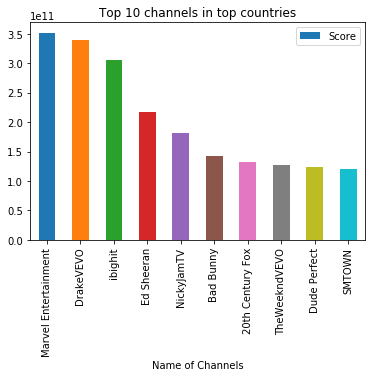

In [60]:
top_channel=top_ten.toPandas()
top_bar=top_channel.plot.bar(x ='Channel_Name', y= "Score")
plt.title("Top 10 channels in top countries")
plt.xlabel("Name of Channels")

<h1>What are WordCloud of title and tags?<h1>

In [61]:
intersect_tag=us_df.select("Tags").intersect(
    gb_df.select("Tags").intersect(
        fr_df.select("Tags").intersect(
            ca_df.select('Tags').intersect(
                de_df.select('Tags')))))
#intersect_tag.select(count("Tags")).show()
intersect_tag.show()

+--------------------+
|                Tags|
+--------------------+
|The Late Late Sho...|
|Enrique Iglesias ...|
|marvel|"comics"|"...|
|The Late Show|"La...|
|Sam|"Smith"|"Pray...|
|Official Trailer|...|
|              [none]|
|Kanye West|"YEEZY...|
|The Tonight Show|...|
|xtina|"kanye west...|
|Maluma Marinero|"...|
|Troye|"Sivan"|"Bl...|
|Childish Gambino|...|
|          bill wurtz|
|Dynamic robots|"B...|
|Bruno Mars and Ca...|
|Jimmy Fallon|"Ton...|
|Trailer|"Deadpool...|
|Charlie|"Puth"|"c...|
|Focus Features|"M...|
+--------------------+
only showing top 20 rows



In [62]:
intersect_tag=intersect_tag.toPandas()

In [63]:
word_string=" ".join(intersect_tag["Tags"].str.lower())
wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='black',
                       max_words=200,
                          max_font_size=100,
                          random_state=35
                         ).generate(word_string)

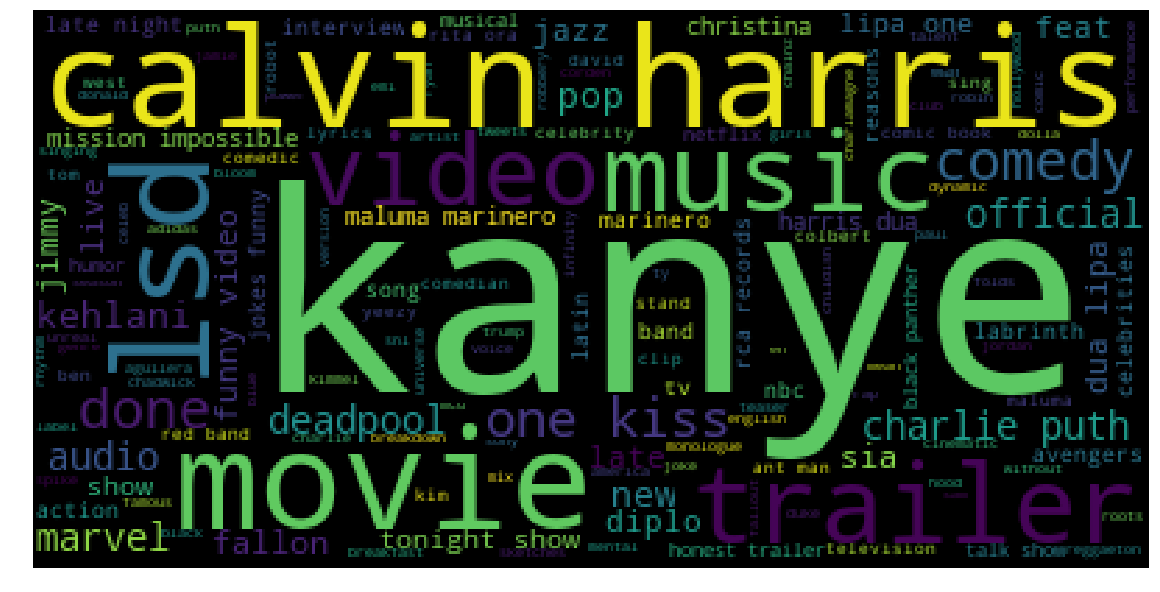

In [64]:
plt.clf()
plt.figure(figsize = (20, 25), facecolor = None)
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('./CAvideosTitleWordCloud.png', dpi=500)
plt.show()

In [65]:
intersect_title=us_df.select("Title").intersect(
    gb_df.select("Title").intersect(
        fr_df.select("Title").intersect(
            ca_df.select("Title").intersect(
                de_df.select("Title")))))
#intersect_tag.select(count("Tags")).show()
intersect_title.show()

+--------------------+
|               Title|
+--------------------+
|Honest Trailers -...|
|Joyner Lucas & Ch...|
|The Poop In My Pa...|
|Eminem - Walk On ...|
|VENOM - Official ...|
|[OFFICIAL VIDEO] ...|
|Lucas the Spider ...|
|Kendrick Lamar, S...|
|P!nk Carpool Karaoke|
|Funny Japanese Ga...|
|Eminem - Walk On ...|
|Musical Genre Cha...|
|Incredibles 2 - O...|
|Charlie Puth - Do...|
|Can Selena Gomez ...|
|Dua Lipa - IDGAF ...|
|Enrique Iglesias ...|
|LSD - Audio ft. S...|
|TWICE Heart Shake...|
|j-hope 'Daydream ...|
+--------------------+
only showing top 20 rows



In [66]:
intersect_title=intersect_title.toPandas()

In [67]:
word_string=" ".join(intersect_title["Title"].str.lower())
wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='black',
                       max_words=200,
                          max_font_size=100,
                          random_state=35
                         ).generate(word_string)

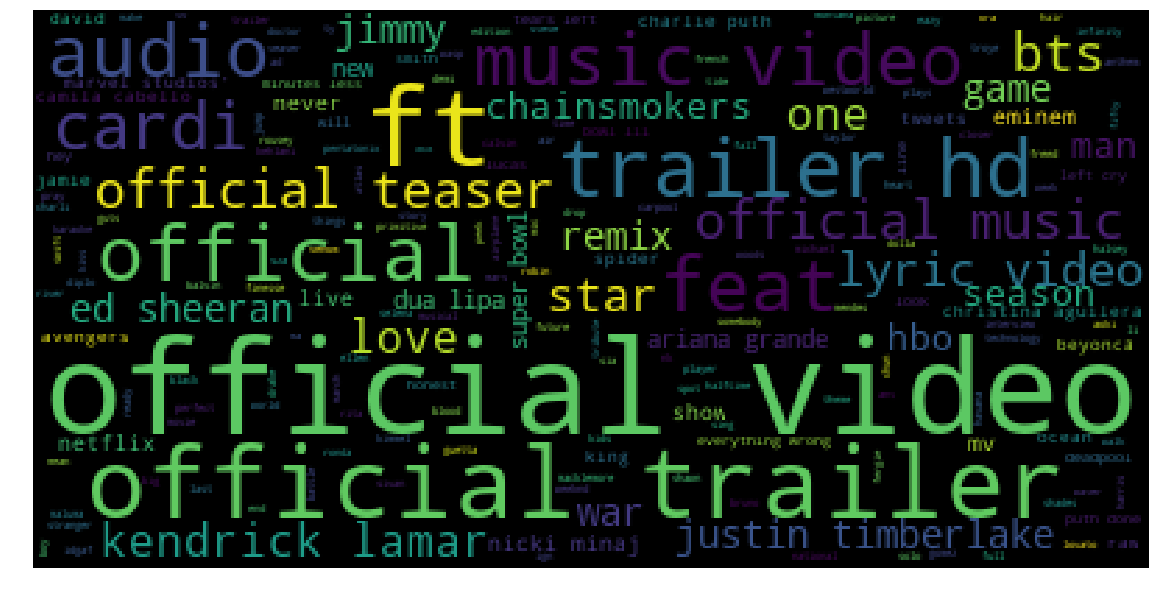

In [68]:
plt.clf()
plt.figure(figsize = (20, 25), facecolor = None)
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('./CAvideosTitleWordCloud.png', dpi=500)
plt.show()

<h1>What are absolute numbers in top countries? <h1> 

In [69]:
ca_numbers=ca_df.select(sum("views"), sum("likes"),sum("dislikes"), sum("comments"))
ca_numbers= ca_numbers.withColumn('Countries', lit("CA").cast(StringType()))
de_numbers=de_df.select(sum("views"), sum("likes"),sum("dislikes"), sum("comments"))
de_numbers= de_numbers.withColumn('Countries', lit("DE").cast(StringType()))
fr_numbers=fr_df.select(sum("views"), sum("likes"),sum("dislikes"), sum("comments"))
fr_numbers= fr_numbers.withColumn('Countries', lit("FR").cast(StringType()))
gb_numbers=gb_df.select(sum("views"), sum("likes"),sum("dislikes"), sum("comments"))
gb_numbers= gb_numbers.withColumn('Countries', lit("GB").cast(StringType()))
us_numbers=us_df.select(sum("views"), sum("likes"),sum("dislikes"), sum("comments"))
us_numbers= us_numbers.withColumn('Countries', lit("US").cast(StringType()))

In [70]:
numbers=ca_numbers.union(
    de_numbers.union(
        fr_numbers.union(
            gb_numbers.union(
                us_numbers))))
numbers.show()

+------------+----------+-------------+-------------+---------+
|  sum(views)|sum(likes)|sum(dislikes)|sum(comments)|Countries|
+------------+----------+-------------+-------------+---------+
| 39667766390|1368410666|     70584402|    171792563|       CA|
| 20214506257| 732748884|     47805277|     92008097|       DE|
| 13875413601| 583673937|     27943623|     59451828|       FR|
|186109924410|4279033175|    248142067|    419468980|       GB|
| 67252508757|2173738168|    109491571|    249777805|       US|
+------------+----------+-------------+-------------+---------+



In [71]:
views= numbers.select('Countries', "sum(views)").toPandas()
views=views.sort_values("sum(views)", ascending = False)
likes= numbers.select('Countries', "sum(likes)").toPandas()
likes=likes.sort_values("sum(likes)", ascending = False)
dislikes= numbers.select('Countries', "sum(dislikes)").toPandas()
dislikes=dislikes.sort_values("sum(dislikes)", ascending = False)
comments= numbers.select('Countries', "sum(comments)").toPandas()
comments=comments.sort_values("sum(comments)", ascending = False)

Text(0.5,1,u'Number of Views in Top Countries')

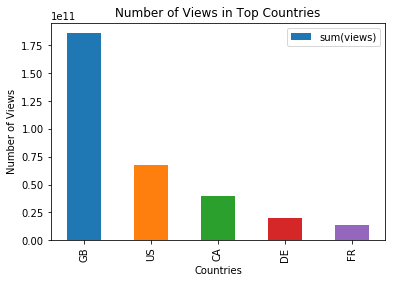

In [72]:
views_bar=views.plot.bar(x ='Countries', y= "sum(views)")
plt.ylabel("Number of Views")
plt.title('Number of Views in Top Countries')

Text(0.5,1,u'Number of Likes in Top Countries')

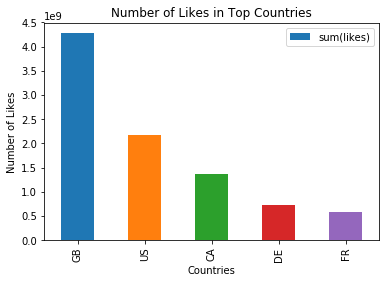

In [73]:
likes_bar=likes.plot.bar(x ='Countries', y= "sum(likes)")
plt.ylabel("Number of Likes")
plt.title('Number of Likes in Top Countries')

Text(0.5,1,u'Number of Dislikes in Top Countries')

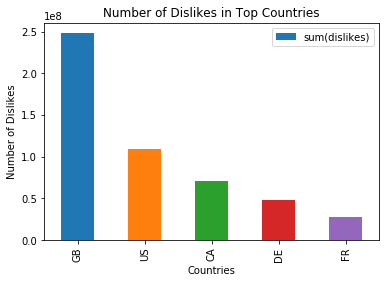

In [74]:
dislikes_bar=dislikes.plot.bar(x ='Countries', y= "sum(dislikes)")
plt.ylabel("Number of Dislikes")
plt.title('Number of Dislikes in Top Countries')

Text(0.5,1,u'Number of Comments in Top Countries')

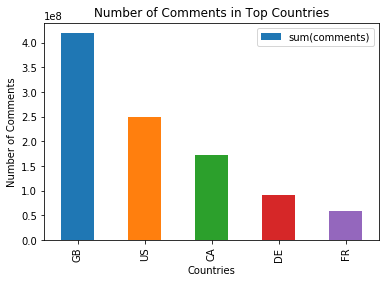

In [75]:
comments_bar=comments.plot.bar(x ='Countries', y= "sum(comments)")
plt.ylabel("Number of Comments")
plt.title('Number of Comments in Top Countries')

<h1>Which categories get more views, comments and likes?<h1>

In [76]:
category_id_dict={2:"Autos& Vehicles", 1: "Film& Animation", 10: "Music", 15: "Pets& Animals", 17: "Sports", 18: "Short Movies",
                  19: "Travel& Events", 20: "Gaming", 21:"Videoblogging", 22: "People& Blogs", 23:"Comedy", 24: "Entertainment", 
                 25: "News & Politics", 26: "Howto & Style", 27: "Education", 28:"Science & Technology",
                29:"Nonprofists & Activism",30:"Movies", 31:"Anime/Animation", 32:"Action/Adventure", 33:"Classics", 34:"Comedy",
                35: "Documentary", 36:"Drama",37: "Family", 38:"Foreign", 39:"Horror", 40:"Sci-Fi/Fantasy", 41:"Thriller", 
                  42:"Shorts", 43:"Shows", 44:"Trailers"}

In [77]:
dictSchema = StructType([ StructField("Category_id", IntegerType(), True)\
                       ,StructField("Category_name", StringType(), True)])
category_id=category_id_dict.items()
category_id_df=spark.createDataFrame(category_id, schema=dictSchema)
category_id_df.show()

+-----------+--------------------+
|Category_id|       Category_name|
+-----------+--------------------+
|          1|     Film& Animation|
|          2|     Autos& Vehicles|
|         10|               Music|
|         15|       Pets& Animals|
|         17|              Sports|
|         18|        Short Movies|
|         19|      Travel& Events|
|         20|              Gaming|
|         21|       Videoblogging|
|         22|       People& Blogs|
|         23|              Comedy|
|         24|       Entertainment|
|         25|     News & Politics|
|         26|       Howto & Style|
|         27|           Education|
|         28|Science & Technology|
|         29|Nonprofists & Act...|
|         30|              Movies|
|         31|     Anime/Animation|
|         32|    Action/Adventure|
+-----------+--------------------+
only showing top 20 rows



In [78]:
ca_values=ca_df.groupBy("Category_id").agg(count("Category_id").alias("CA"))
gb_values=gb_df.groupBy("Category_id").agg(count("Category_id").alias("GB"))
us_values=us_df.groupBy("Category_id").agg(count("Category_id").alias("US"))
fr_values=fr_df.groupBy("Category_id").agg(count("Category_id").alias("FR"))
de_values=de_df.groupBy("Category_id").agg(count("Category_id").alias("DE"))
categories=us_values.join(ca_values, on="Category_id")
categories=categories.join(de_values, on="Category_id")
categories=categories.join(fr_values, on="Category_id")
categories=categories.join(gb_values, on="Category_id")
categories= categories.withColumn('Number of Videos', categories["CA"]+categories["GB"]\
                                  +categories["US"]+categories["DE"]+categories["FR"])
categories.show()

+-----------+----+-----+-----+----+-----+----------------+
|Category_id|  US|   CA|   DE|  FR|   GB|Number of Videos|
+-----------+----+-----+-----+----+-----+----------------+
|         28|2152|  989|  724| 710|  484|            5059|
|         26|3630| 1692| 1517|2116| 1912|           10867|
|         27|1505|  902|  770| 648|  451|            4276|
|         22|2894| 3682| 5255|4990| 2699|           19520|
|          1|1978| 1784| 2059|1869| 2259|            9949|
|         20| 563| 1137| 1411|1299| 1550|            5960|
|         19| 372|  340|  127| 109|   96|            1044|
|         15| 818|  305|  220| 208|  472|            2023|
|         17|1964| 2416| 2381|3704| 1741|           12206|
|         23|2992| 3313| 2166|3753| 1637|           13861|
|         10|5245| 3229| 2008|3447|11693|           25622|
|         25|2261| 3540| 2605|3328| 1076|           12810|
|         24|8510|11462|12945|8230| 8005|           49152|
|         29|  48|   74|  240| 106|   78|             54

In [79]:
categories=categories.join(category_id_df, on="Category_id")
categories.show()

+-----------+----+-----+-----+----+-----+----------------+--------------------+
|Category_id|  US|   CA|   DE|  FR|   GB|Number of Videos|       Category_name|
+-----------+----+-----+-----+----+-----+----------------+--------------------+
|         28|2152|  989|  724| 710|  484|            5059|Science & Technology|
|         26|3630| 1692| 1517|2116| 1912|           10867|       Howto & Style|
|         27|1505|  902|  770| 648|  451|            4276|           Education|
|         22|2894| 3682| 5255|4990| 2699|           19520|       People& Blogs|
|          1|1978| 1784| 2059|1869| 2259|            9949|     Film& Animation|
|         20| 563| 1137| 1411|1299| 1550|            5960|              Gaming|
|         19| 372|  340|  127| 109|   96|            1044|      Travel& Events|
|         15| 818|  305|  220| 208|  472|            2023|       Pets& Animals|
|         17|1964| 2416| 2381|3704| 1741|           12206|              Sports|
|         23|2992| 3313| 2166|3753| 1637

In [80]:
categories=categories.toPandas()

Text(0.5,1,u'Number of Videos per Category')

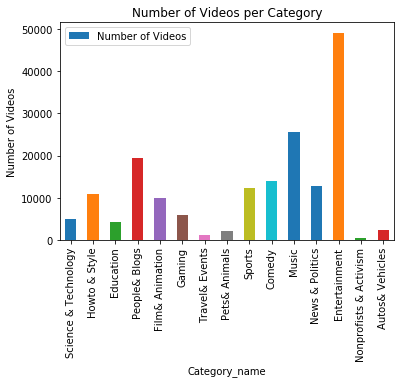

In [81]:
categories_bar=categories.plot.bar(x ='Category_name', y= "Number of Videos")
plt.ylabel("Number of Videos")
plt.title('Number of Videos per Category')

<h1>How much time passes between published and trending?<h1>

In [28]:
df_time_passed_ca=ca_df.groupBy("Time_Passed").count().sort("Time_Passed")

df_time_passed_de=de_df.groupBy("Time_Passed").count().sort("Time_Passed")

df_time_passed_fr=fr_df.groupBy("Time_Passed").count().sort("Time_Passed")

df_time_passed_gb=gb_df.groupBy("Time_Passed").count().sort("Time_Passed")

df_time_passed_us=us_df.groupBy("Time_Passed").count().sort("Time_Passed")

In [29]:
ca_pd=df_time_passed_ca.withColumn("Time_Passed",df_time_passed_ca.Time_Passed).limit(20).toPandas()
de_pd=df_time_passed_de.withColumn("Time_Passed",df_time_passed_de.Time_Passed).limit(20).toPandas()
fr_pd=df_time_passed_fr.withColumn("Time_Passed",df_time_passed_fr.Time_Passed).limit(20).toPandas()
gb_pd=df_time_passed_gb.withColumn("Time_Passed",df_time_passed_gb.Time_Passed).limit(20).toPandas()
us_pd=df_time_passed_us.withColumn("Time_Passed",df_time_passed_us.Time_Passed).limit(20).toPandas()

Text(0.5,1,u'Number of Days Passed Between Published and Trending Time')

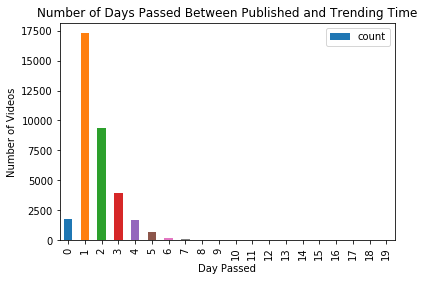

In [30]:
ca_time=ca_pd.plot.bar(x ='Time_Passed', y= "count")
plt.ylabel("Number of Videos")
plt.xlabel("Day Passed")
plt.title("Number of Days Passed Between Published and Trending Time")

Text(0.5,1,u'Number of Days Passed Between Published and Trending Time')

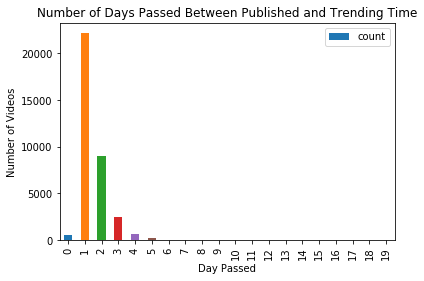

In [31]:
de_time=de_pd.plot.bar(x ='Time_Passed', y= "count")
plt.ylabel("Number of Videos")
plt.xlabel("Day Passed")
plt.title("Number of Days Passed Between Published and Trending Time")

Text(0.5,1,u'Number of Days Passed Between Published and Trending Time')

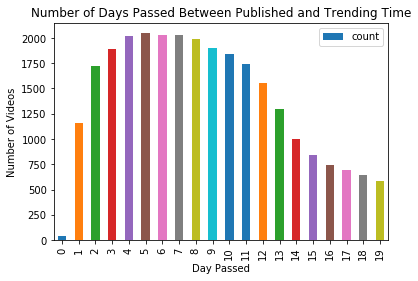

In [32]:
gb_time=gb_pd.plot.bar(x ='Time_Passed', y= "count")
plt.ylabel("Number of Videos")
plt.xlabel("Day Passed")
plt.title("Number of Days Passed Between Published and Trending Time")

Text(0.5,1,u'Number of Days Passed Between Published and Trending Time')

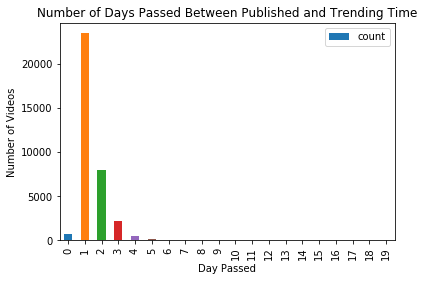

In [33]:
fr_time=fr_pd.plot.bar(x ='Time_Passed', y= "count")
plt.ylabel("Number of Videos")
plt.xlabel("Day Passed")
plt.title("Number of Days Passed Between Published and Trending Time")

Text(0.5,1,u'Number of Days Passed Between Published and Trending Time')

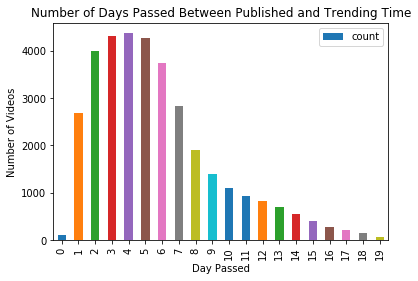

In [34]:
us_time=us_pd.plot.bar(x ='Time_Passed', y= "count")
plt.ylabel("Number of Videos")
plt.xlabel("Day Passed")
plt.title("Number of Days Passed Between Published and Trending Time")

<h1>How much time passes between published and trending dates for categories for top countries?<h1>

In [35]:
ca_category_time=ca_df.groupBy("Category_Id")\
    .agg(avg("Time_passed").alias("ca_average_time"))
us_category_time=us_df.groupBy("Category_Id")\
    .agg(avg("Time_passed").alias("us_average_time"))
de_category_time=de_df.groupBy("Category_Id")\
    .agg(avg("Time_passed").alias("de_average_time"))
gb_category_time=gb_df.groupBy("Category_Id")\
    .agg(avg("Time_passed").alias("gb_average_time"))
fr_category_time=fr_df.groupBy("Category_Id")\
    .agg(avg("Time_passed").alias("fr_average_time"))

In [36]:
category_id_dict={2:"Autos& Vehicles", 1: "Film& Animation", 10: "Music", 15: "Pets& Animals", 17: "Sports", 18: "Short Movies",
                  19: "Travel& Events", 20: "Gaming", 21:"Videoblogging", 22: "People& Blogs", 23:"Comedy", 24: "Entertainment", 
                 25: "News & Politics", 26: "Howto & Style", 27: "Education", 28:"Science & Technology",
                29:"Nonprofists & Activism",30:"Movies", 31:"Anime/Animation", 32:"Action/Adventure", 33:"Classics", 34:"Comedy",
                35: "Documentary", 36:"Drama",37: "Family", 38:"Foreign", 39:"Horror", 40:"Sci-Fi/Fantasy", 41:"Thriller", 
                  42:"Shorts", 43:"Shows", 44:"Trailers"}

In [37]:
dictSchema = StructType([ StructField("Category_id", IntegerType(), True)\
                       ,StructField("Category_name", StringType(), True)])
category_id=category_id_dict.items()
category_id_df=spark.createDataFrame(category_id, schema=dictSchema)
ca_join=ca_category_time.join(category_id_df, on="Category_id")
us_join=us_category_time.join(category_id_df, on="Category_id")
de_join=de_category_time.join(category_id_df, on="Category_id")
gb_join=gb_category_time.join(category_id_df, on="Category_id")
fr_join=fr_category_time.join(category_id_df, on="Category_id")

In [38]:
joined_countries=fr_join.select("Category_id","fr_average_time").join(
    gb_join.select("Category_id","gb_average_time").join(
        de_join.select("Category_id","de_average_time").join(
            ca_join.join(us_join.select("Category_id","us_average_time"), 
                         on="Category_id"),on="Category_id"),on="Category_id"), on="Category_id")
joined_countries.show()

+-----------+------------------+------------------+------------------+------------------+--------------------+------------------+
|Category_id|   fr_average_time|   gb_average_time|   de_average_time|   ca_average_time|       Category_name|   us_average_time|
+-----------+------------------+------------------+------------------+------------------+--------------------+------------------+
|         28|1.9211267605633804|15.535123966942148| 2.095303867403315|10.661274014155714|Science & Technology|18.864312267657994|
|         26|2.9130434782608696|13.259937238493723|1.3111404087013843|1.6495271867612293|       Howto & Style| 7.413498622589532|
|         27| 6.689814814814815| 152.1042128603104|1.4285714285714286|3.4445676274944566|           Education|40.692358803986714|
|         22|3.2372745490981965| 73.41200444609115|1.9984776403425308| 3.866376969038566|       People& Blogs|16.205943331029715|
|          1|3.5082932049224183|42.836210712704734| 2.325886352598349| 8.617713004484305| 

In [39]:
joined_countries=joined_countries.withColumn("total_times_per_category", 
                (joined_countries["fr_average_time"]+joined_countries["gb_average_time"]+joined_countries["de_average_time"]+
                 joined_countries["us_average_time"]+joined_countries["ca_average_time"])/5)
joined_countries.select("Category_name","total_times_per_category").show()

+--------------------+------------------------+
|       Category_name|total_times_per_category|
+--------------------+------------------------+
|Science & Technology|       9.815428175344511|
|       Howto & Style|       5.309429386961348|
|           Education|       40.87190510703556|
|       People& Blogs|      19.744015387120033|
|     Film& Animation|      20.781179805599187|
|              Gaming|       9.412352736710144|
|      Travel& Events|      23.283708125612872|
|       Pets& Animals|       5.953810502190618|
|              Sports|      14.112437740225392|
|              Comedy|        23.5930118300356|
|               Music|      14.413175683661512|
|     News & Politics|       6.993941587904741|
|       Entertainment|       9.054271692639677|
|Nonprofists & Act...|      5.8825982295793615|
|     Autos& Vehicles|      20.207441152605934|
+--------------------+------------------------+



In [40]:
df_pd_category_times=joined_countries.toPandas()

Text(0.5,1,u'Times for trending for categories (in days)')

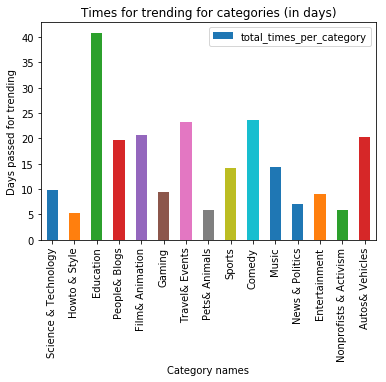

In [41]:
trend_category_bar=df_pd_category_times.plot.bar(x ='Category_name', y= "total_times_per_category")
plt.ylabel("Days passed for trending")
plt.xlabel("Category names")
plt.title("Times for trending for categories (in days)")

<h1>Prediction<h1>

In [42]:
gb_mlframe=gb_df.select("Category_Id","Views","Likes","Dislikes", "Comments")

gb_features = list()
for col in gb_mlframe.columns:
    if 'Category_Id' in col:continue
    gb_features.append(col)  

In [43]:
assembler= VectorAssembler(inputCols=gb_features,
                           outputCol="gb_features")
#assembler.transform(mlframe)
gb_feature_df = assembler.transform(gb_mlframe)

training_df, testing_df = gb_feature_df.randomSplit([0.8, 0.2], seed=42)

In [44]:
standard_scaler = StandardScaler(inputCol="gb_features", outputCol="gb_scaled", withMean=True, withStd=True)

scaler_model = standard_scaler.fit(training_df)

train_scaled = scaler_model.transform(training_df)
test_scaled = scaler_model.transform(testing_df)

In [45]:
lr = LinearRegression(featuresCol='gb_scaled', labelCol='Category_Id')
model = lr.fit(train_scaled)
model.coefficients

DenseVector([0.0514, -2.3553, -0.4258, 1.6305])

In [46]:
preds = model.transform(test_scaled)
preds.show(5)

+-----------+-----+-----+--------+--------+--------------------+--------------------+------------------+
|Category_Id|Views|Likes|Dislikes|Comments|         gb_features|           gb_scaled|        prediction|
+-----------+-----+-----+--------+--------+--------------------+--------------------+------------------+
|          1| 2938|   69|       2|       0|[2938.0,69.0,2.0,...|[-0.2977020077963...|17.542387030495476|
|          1| 8328|   56|       0|      13|[8328.0,56.0,0.0,...|[-0.2974084007366...|17.542958005424286|
|          1| 8925|   60|       0|      13|[8925.0,60.0,0.0,...|[-0.2973758806226...|17.542929886946556|
|          1|13701|  249|       3|      26|[13701.0,249.0,3....|[-0.2971157197103...| 17.54195658807486|
|          1|14406|  260|       3|      26|[14406.0,260.0,3....|[-0.2970773165605...|   17.541876638476|
+-----------+-----+-----+--------+--------+--------------------+--------------------+------------------+
only showing top 5 rows



In [47]:
re = RegressionEvaluator(predictionCol='prediction', labelCol='Category_Id', metricName='rmse')
re.evaluate(preds)

7.580269578759882